## Notebook to analyze TH PF_Fzd5
Thalamus medium sized subclass group. Seems to label parafasicular nucleus

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [2]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig

# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

In [3]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# TH MH_Tac2 is a medium large sized subclass within dataset
gluTypes = gluData.obs.subclass_label.unique()
gluCounts = pd.DataFrame([sum(gluData.obs.subclass_label == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

,Count
TH Prkcd_Grin2c,23362
TH_Rxfp1_Epb4,10411
TH PVT_Ntrk1,5419
TH/HY Gbx2 Zim1,5006
TH MH_Tac2,4405
TH AV_Col27a1,3011
TH PF_Fzd5,2500
TH LH_Pou4f1_Sox1,1346
TH Tfap2d,774
TH Serpinb7,398


In [5]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "TH PF_Fzd5"
genesRanked = pd.DataFrame(
        {key: gluData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False)
genesRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Lypd6b,0.0,83.459175,11.672716,0.9960,0.194828,0.801172
1,Etl4,0.0,81.362503,6.346422,0.9996,0.830959,0.168641
2,Cbln4,0.0,81.053276,9.748816,0.9900,0.369814,0.620186
3,Lhfpl3,0.0,78.020187,3.304827,1.0000,0.984681,0.015319
4,Hs3st4,0.0,77.076874,9.704597,0.9772,0.444349,0.532851
...,...,...,...,...,...,...,...
23426,Zic1,0.0,-66.000526,-4.936090,0.7348,0.927580,-0.192780
23427,Cdk14,0.0,-66.154770,-2.092897,0.9840,0.997720,-0.013720
23428,Rtn4rl1,0.0,-70.111900,-6.151050,0.4764,0.932887,-0.456487
23429,Olfm1,0.0,-70.285522,-3.317280,0.9492,0.991574,-0.042374


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TH PF_Fzd5 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

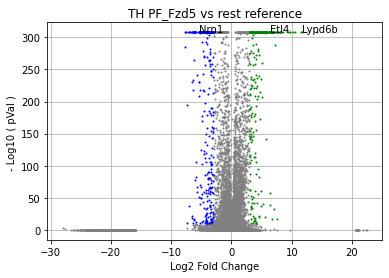

In [6]:
# Create volcano plot
plotVolcano(gluData,indx,label=["Lypd6b", "Etl4", "Nrn1"])

In [9]:
# Take top 500 "score" genes
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
genesFiltered = genesRanked.iloc[0:500,:]
genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
genesFiltered.head(20)

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
8,Ctxn3,0.0,75.924133,14.151857,0.9020,0.027028,0.874972
10,Fzd5,0.0,75.558815,11.610750,0.8980,0.031076,0.866924
0,Lypd6b,0.0,83.459175,11.672716,0.9960,0.194828,0.801172
6,Lypd6,0.0,76.114075,10.283254,0.9580,0.181898,0.776102
24,1700011I03Rik,0.0,66.029739,10.604140,0.7904,0.028888,0.761512
11,Lmo1,0.0,74.302666,8.544710,0.9468,0.199424,0.747376
34,Rprm,0.0,63.046314,7.620906,0.8712,0.184725,0.686475
54,Lhfpl2,0.0,58.117867,7.601533,0.7400,0.085186,0.654814
14,Rhbdl3,0.0,72.676857,7.974205,0.9536,0.300822,0.652778
57,Fndc1,0.0,57.702759,6.818769,0.7580,0.124323,0.633677


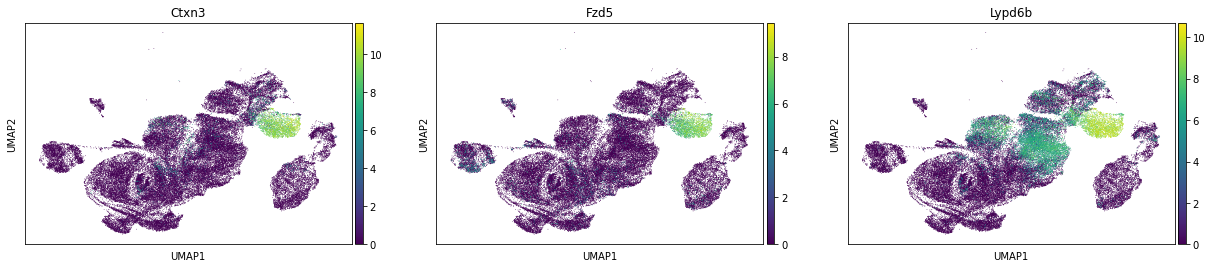

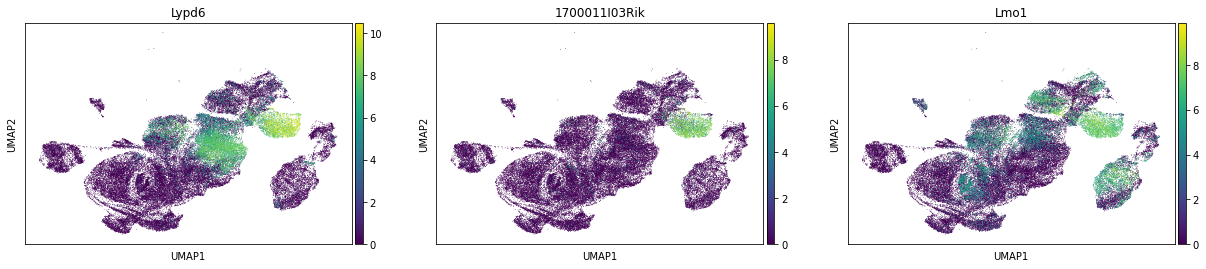

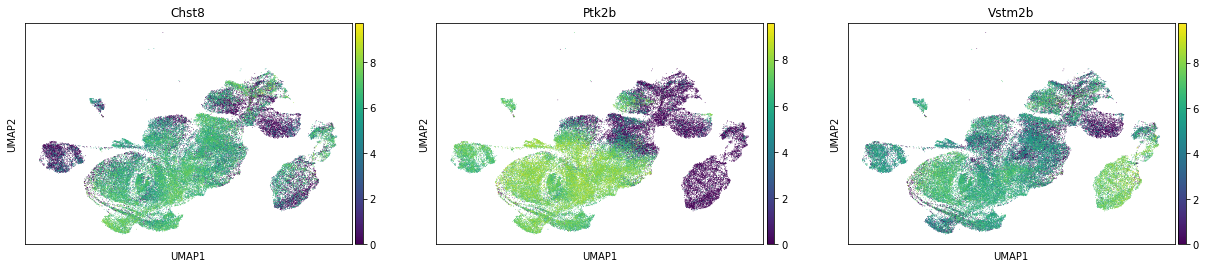

In [10]:
# Plot expression of several potential marker genes
# These genes are highly expressed in MH, but not elsewhere
sc.pl.umap(gluData, color = genesFiltered["names"][0:3])
sc.pl.umap(gluData, color = genesFiltered["names"][3:6])
# Plot expression of several genes which are expressed elsewhere, but not MH
sc.pl.umap(gluData, color = genesFiltered["names"][-3:])

In [11]:
# Look at marker gene overlap
markerGenes = {
    'TH PF_Fzd5' : genesFiltered["names"][:5].tolist(),
    'Downregulated' : genesFiltered["names"][-5:].tolist(),
    'TH Serpinb7' : ["C1ql2", "Stk32b", "Scn7a", "Megf11"],
}
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="overlap_count", top_n_markers=50, inplace=False)
markerOverlap

,HY Foxa1,HY Pitx2,TH AV_Col27a1,TH LH_Pou4f1_Sox1,TH MH_Tac2,TH PF_Fzd5,TH PVT_Ntrk1,TH Pitx2,TH Prkcd_Grin2c,TH Serpinb7,TH Tfap2d,TH/HY Gbx2 Fmo1,TH/HY Gbx2 Zim1,TH/HY Pth2,TH_Rxfp1_Epb4
TH PF_Fzd5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Downregulated,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TH Serpinb7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


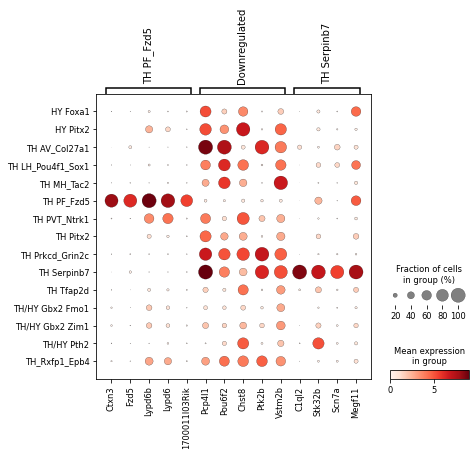

In [12]:
# Dotplot of marker gene expression in various groups
sc.pl.dotplot(gluData,markerGenes,"subclass_label", dendrogram = False)

## TH PF_Fzd5 subcluster analysis
Look at how the 12 clusters within the PF_Fzd5 subclass differ

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


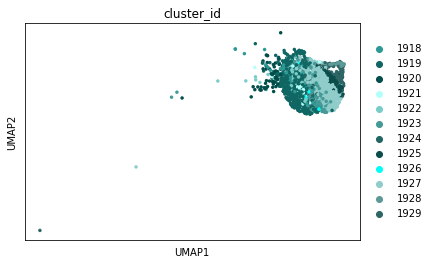

In [13]:
# Index by cell class
indx = "TH PF_Fzd5"
clData = gluData[gluData.obs.subclass_label == indx]
color_dict = dict(zip(clData.obs["cluster_id"],clData.obs["cluster_color"]))
sc.pl.umap(clData, color="cluster_id",palette=color_dict)

In [14]:
# Get counts of each cluster type
clTypes = clData.obs.cluster_id.unique()
clCounts = pd.DataFrame([sum(clData.obs.cluster_id == name) for name in clTypes], columns= ["Count"], index = clTypes)
clCounts = clCounts.sort_values(by = "Count", ascending=False)
clCounts

,Count
1919,753
1927,676
1923,374
1929,126
1926,118
1924,94
1918,86
1922,69
1920,69
1925,65


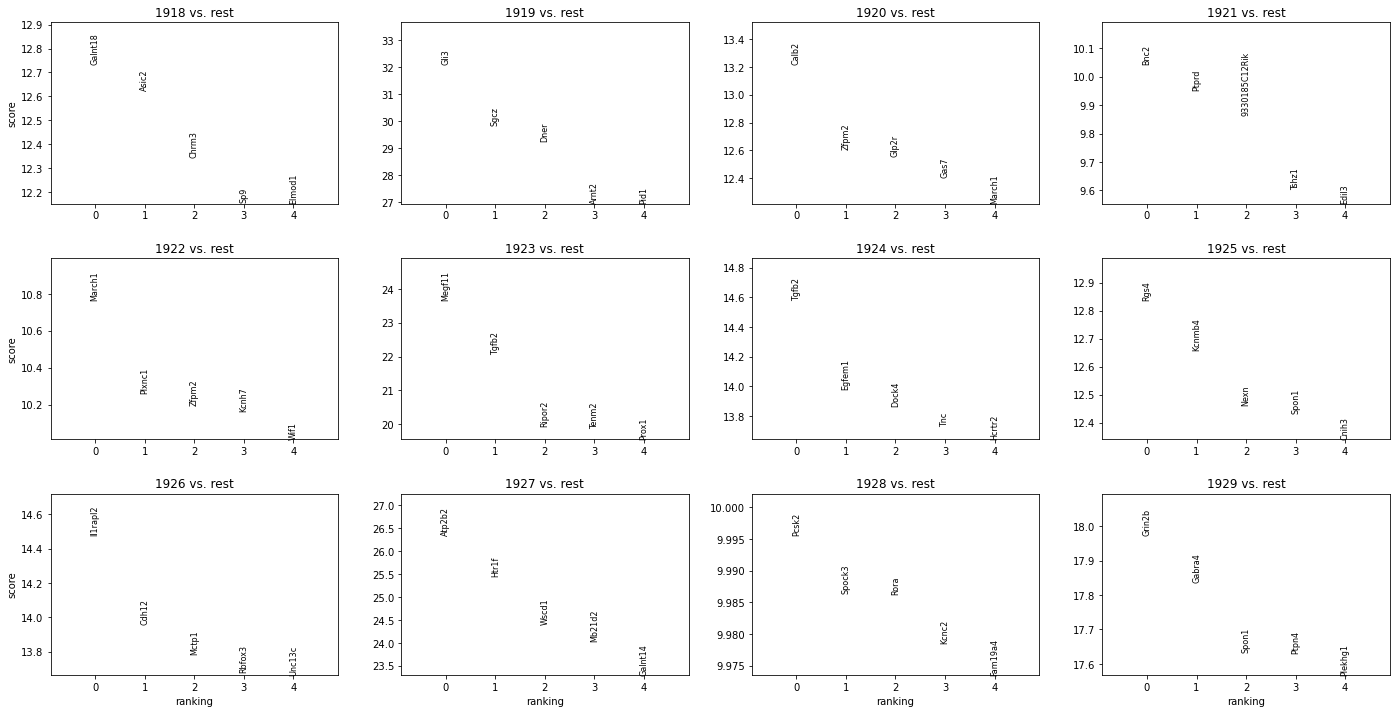

In [17]:
# Look for differential expression between clusters
sc.tl.rank_genes_groups(clData, 'cluster_id', method='wilcoxon', pts=True)
sc.pl.rank_genes_groups(clData, n_genes=5, sharey=False)

In [34]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "1929"
clRanked = pd.DataFrame(
        {key: clData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = clData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = clData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
clRanked = pd.concat([clRanked, pts, pts_rest, pts_diff], axis=1)
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Grin2b,3.176830e-72,17.972897,2.531554,1.000000,0.995788,0.004212
1,Gabra4,3.582032e-71,17.838015,4.107836,1.000000,0.999579,0.000421
2,Spon1,1.360251e-69,17.633600,9.854858,0.992063,0.989890,0.002173
3,Ptpn4,1.445067e-69,17.630180,3.000585,1.000000,1.000000,0.000000
4,Plekhg1,4.317721e-69,17.568184,9.301619,1.000000,0.975990,0.024010
...,...,...,...,...,...,...,...
10851,Vmn1r194,1.000000e+00,0.000000,0.000000,0.007937,0.015164,-0.007228
10850,Vmn1r196,1.000000e+00,0.000000,0.000000,0.380952,0.373631,0.007321
10849,Vmn1r198,1.000000e+00,0.000000,0.000000,0.888889,0.911963,-0.023074
10848,Vmn1r199,1.000000e+00,0.000000,0.000000,0.023810,0.010110,0.013700


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'1929 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

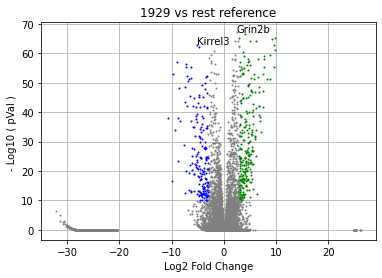

In [35]:
# Query volcano plots for various clusters
plotVolcano(clData,indx)

In [36]:
# Take top 500 "score" genes, filtered out for atleast 2 logfold change
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clFiltered = clRanked.iloc[0:500,:]
clFiltered = clFiltered[clFiltered["logfoldchanges"] > abs(2)]
clFiltered = clFiltered.sort_values(by=["pts_diff"], ascending=False)
clFiltered.head(10)

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
22,Tmem56,1.513253e-61,16.553394,4.606448,0.888889,0.454507,0.434382
277,Napepld,3.215163e-26,10.592888,3.775960,0.761905,0.333193,0.428712
230,Map6d1,6.484113e-29,11.158828,4.501684,0.968254,0.544229,0.424025
264,Rgs3,2.348512e-27,10.835045,3.989783,0.468254,0.044229,0.424025
223,5033430I15Rik,1.448709e-29,11.291305,4.521916,0.698413,0.277169,0.421243
181,Nr4a1,2.642996e-34,12.213196,4.639742,0.944444,0.540438,0.404006
189,Kctd17,2.850566e-33,12.018217,2.454044,0.952381,0.551811,0.400570
197,Lingo1,1.687562e-32,11.870352,2.051908,0.793651,0.419124,0.374527
234,Lypd6,8.600279e-29,11.133687,2.155263,0.880952,0.512637,0.368315
131,Fam81a,1.742834e-39,13.148196,4.072206,0.801587,0.440185,0.361402


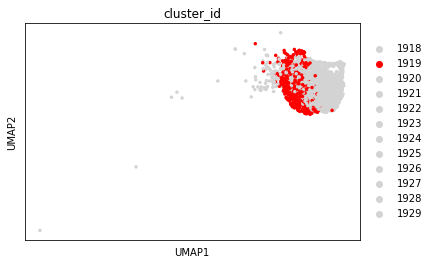

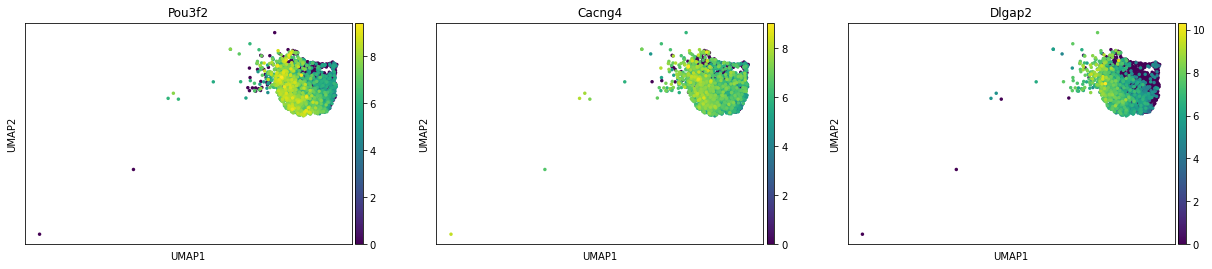

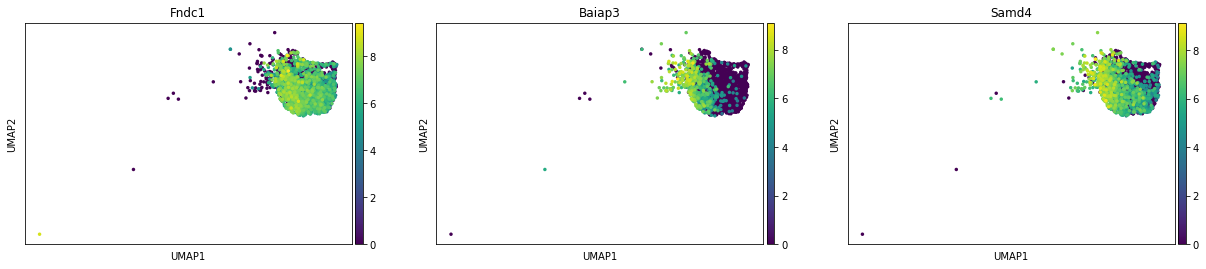

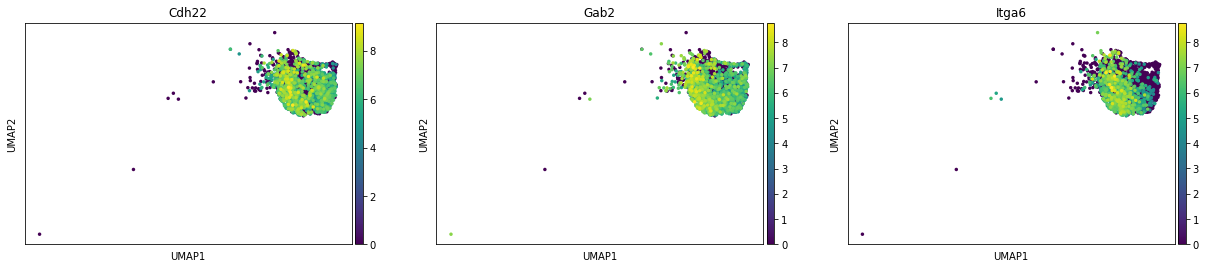

In [22]:
# Plot expression of several potential marker genes
maskPalette = create_mask_dict(clData.obs.cluster_id.unique(),indx)
sc.pl.embedding(clData, "umap", color = "cluster_id", palette=maskPalette)

sc.pl.umap(clData, color = clFiltered["names"][0:3])
sc.pl.umap(clData, color = clFiltered["names"][3:6])
sc.pl.umap(clData, color = clFiltered["names"][-3:])

## Other stuff

## Link to Allen ISH

### Subclass

Fzd5, perhaps broad expression, but clearly enriched in parafasicular nucleus and perhaps interomediodorsal  
https://mouse.brain-map.org/experiment/show/100145366

Lypd6b, Paracentral, parafasicular nucleus  
https://mouse.brain-map.org/experiment/show/73635774

Lmo1, also parafasciular  
https://mouse.brain-map.org/experiment/show/1373

### Clusters

Cluster 1919, Baiap3 expression, seems to express on dorsal side of parafasicular nucleus  
https://mouse.brain-map.org/experiment/show/75081206
 
Cluster 1927  Pstpip1 expression, seems to label ventrolateral part of PF - CPU projecting?
https://mouse.brain-map.org/experiment/show/71717135

Cluster 1923 Megf11 expression, seems to label dorsomedial part of PF just around fr. [Pdyn looks similar](https://mouse.brain-map.org/experiment/show/71717084) - NAc projecting?  
https://mouse.brain-map.org/experiment/show/74357580

Cluster 1929 Nr4a1 expression, looks like lateral PF - CPU or STN?  
https://mouse.brain-map.org/experiment/show/1792


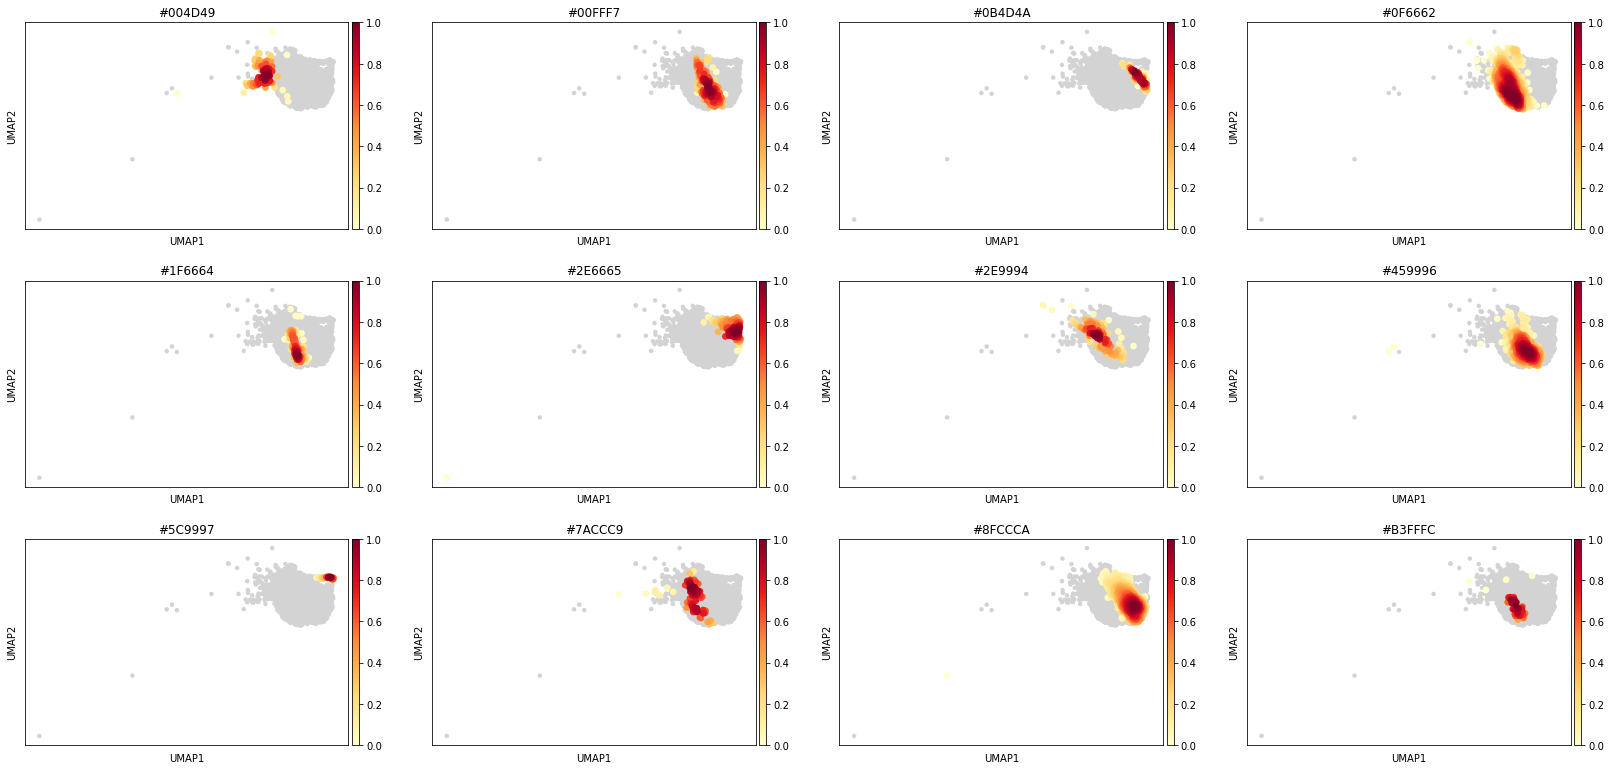

In [15]:
# Embedding densitt key seems to break down for fully numeric names, grouping by cluster color seems to work though
sc.tl.embedding_density(clData, basis="umap",groupby="cluster_color")
sc.pl.embedding_density(clData, basis="umap", key="umap_density_cluster_color")

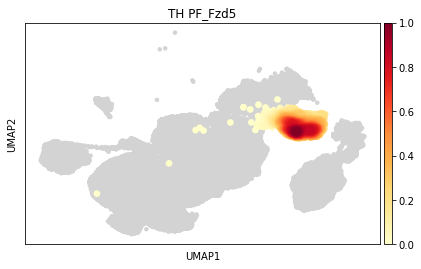

In [16]:
sc.tl.embedding_density(gluData, basis="umap", groupby="subclass_label")
sc.pl.embedding_density(gluData, basis="umap", key="umap_density_subclass_label", group=indx)